In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import numpy as np
import torch
G = 9.81

In [3]:
# Initialize some flow into the system
U = [np.round(np.random.random()) for u in range(100)]
print(U)

[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]


In [4]:
# Initialize the network size
Buckets_Per_Layer = [1,2,3,2,1] # Buckets Per Layer
print(len(Buckets_Per_Layer))

5


In [5]:
def get_initial_parameters_of_one_bucket(n_spigots):
    return [(np.random.random(),np.random.random()) for _ in range(n_spigots)]

In [6]:
def initialize_up_bucket_network(bpl):
    """Sets up the network of buckets
        Args: 
            bpl (list): the buckets per layer
    """
    bucket_network = []
    for ilayer, n_buckets in enumerate(bpl):
        if ilayer < len(bpl)-1:
            n_spigots = bpl[ilayer+1]
        else:
            n_spigots = 1
        spigots = [get_initial_parameters_of_one_bucket(n_spigots) for jbucket in range(n_buckets)]
        bucket_network.append(spigots)
    return bucket_network

In [7]:
ncnn = initialize_up_bucket_network(Buckets_Per_Layer)

In [8]:
for i in ncnn:
    for j in i:
        print("These are the characteristics of each spigot in a single bucket")
        print(j)
        for k in j:
            print("This is an individual spigot")
            print(k)

These are the characteristics of each spigot in a single bucket
[(0.7016825753626353, 0.5493425108512037), (0.8745577257185166, 0.11284798790020534)]
This is an individual spigot
(0.7016825753626353, 0.5493425108512037)
This is an individual spigot
(0.8745577257185166, 0.11284798790020534)
These are the characteristics of each spigot in a single bucket
[(0.355872874824841, 0.7227123553210375), (0.735761010076635, 0.008452357044610004), (0.0009575398419389147, 0.5623335796808708)]
This is an individual spigot
(0.355872874824841, 0.7227123553210375)
This is an individual spigot
(0.735761010076635, 0.008452357044610004)
This is an individual spigot
(0.0009575398419389147, 0.5623335796808708)
These are the characteristics of each spigot in a single bucket
[(0.07350655816540985, 0.9057487756943852), (0.3662341471493944, 0.4215068343420151), (0.5084890288882912, 0.7751328666104004)]
This is an individual spigot
(0.07350655816540985, 0.9057487756943852)
This is an individual spigot
(0.3662341

In [9]:
def bucket_n(H, spigots, dt):
    """ solves a single bucket
        Args: 
            H (float): the water level in bucket
            spigots (list): the characteristics of the bucket outlets
                                        spigots[0]: Height of spigots, 
                                        spigots[1]: size of spigots
            dt (float): the timestep in hours
        Returns:
            H (float): the new water level in bucket
            v (list): The total ammount of water out of each spigot
    """
    convervence = 100
    for sp_h, sp_a in spigots:
        dh = np.max(0, H - sp_h)
        flow_out = np.sqrt(2 * G * H) * sp_a
    H = None
    v = None
    
    return H, v

In [11]:
bucket_n(100, [[1,2],[0.2,0.3]], 1)

AxisError: axis 99 is out of bounds for array of dimension 0

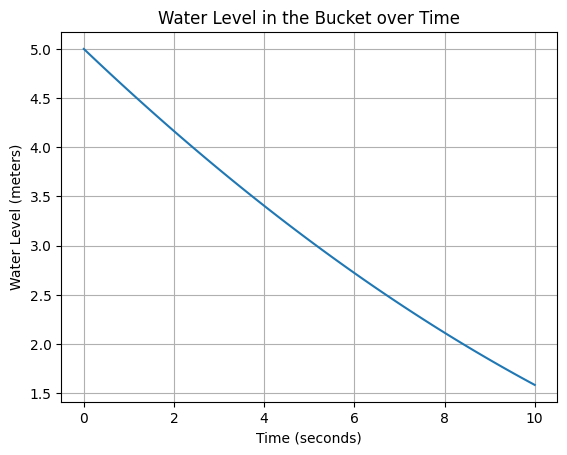

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def bucket_flow_out(total_time, dt, initial_height, hole_areas, hole_coefficients):
    num_steps = int(total_time / dt)
    time = np.linspace(0, total_time, num_steps + 1)
    water_level = np.zeros(num_steps + 1)
    water_level[0] = initial_height

    for i in range(num_steps):
        flow_in = 0  # Assuming no flow into the bucket

        # Calculate the flow rates out of each hole based on the water level
        flow_out = 0
        for hole_area, hole_coefficient in zip(hole_areas, hole_coefficients):
            flow_out += hole_coefficient * np.sqrt(2 * 9.81 * water_level[i]) * hole_area

        water_level[i + 1] = water_level[i] + dt * (flow_in - flow_out)

    return time, water_level

# Example usage
total_time = 10  # Total simulation time (seconds)
dt = 0.1  # Time step (seconds)
initial_height = 5  # Initial water level in the bucket (meters)
hole_areas = [0.01, 0.02, 0.03]  # Areas of the three holes (m^2)
hole_coefficients = [0.6, 0.7, 0.8]  # Coefficients for each hole

time, water_level = bucket_flow_out(total_time, dt, initial_height, hole_areas, hole_coefficients)

# Plotting the results
plt.plot(time, water_level)
plt.xlabel('Time (seconds)')
plt.ylabel('Water Level (meters)')
plt.title('Water Level in the Bucket over Time')
plt.grid(True)
plt.show()